In [1]:
# --------------------
# Mount Google Drive (if using)
# --------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# --------------------
# Configuration
# --------------------
USE_BITMASKS_ONLY = True  # Set to False to use both images and bitmasks

# Change this path based on where your data is in Google Drive
BASE_DIR = '/content/drive/MyDrive/ECS 193/CNN/selected_data'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
BITMASK_DIR = os.path.join(BASE_DIR, 'bitmasks')
CSV_PATH = os.path.join(BASE_DIR, 'selected_data.csv')

IMG_HEIGHT, IMG_WIDTH = 480, 640
BATCH_SIZE = 32
EPOCHS = 20

# --------------------
# Load and Validate CSV
# --------------------
df = pd.read_csv(CSV_PATH)

# Create full image/mask paths
df['bitmask_path'] = df['image'].apply(lambda x: os.path.join(BITMASK_DIR, x.replace('.png', '_mask.png')))
if not USE_BITMASKS_ONLY:
    df['image_path'] = df['image'].apply(lambda x: os.path.join(IMAGE_DIR, x))
    df = df[df['image_path'].apply(os.path.exists) & df['bitmask_path'].apply(os.path.exists)]
else:
    df = df[df['bitmask_path'].apply(os.path.exists)]

print(f"✅ Found {len(df)} valid {'bitmask' if USE_BITMASKS_ONLY else 'image + bitmask'} data points")

# --------------------
# Data Loader
# --------------------
def load_data(row):
    if USE_BITMASKS_ONLY:
        mask = cv2.imread(row['bitmask_path'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = mask.astype(np.float32) / 255.0
        return np.expand_dims(mask, axis=-1)
    else:
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img.astype(np.float32) / 255.0

        mask = cv2.imread(row['bitmask_path'], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = mask.astype(np.float32) / 255.0
        return np.concatenate([img, np.expand_dims(mask, axis=-1)], axis=-1)

# --------------------
# Load Full Dataset
# --------------------
print("📦 Loading image data into memory...")
X = np.array([load_data(row) for _, row in df.iterrows()])
y = df[['steering_angle', 'speed']].values.astype(np.float32)

print(f"Input shape: {X.shape} | Output shape: {y.shape}")

# --------------------
# Full Dataset Split: Train, Validation, Test
# --------------------
from sklearn.model_selection import train_test_split

# # First split: 90% temp (train + val), 10% test
# X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# # Second split: 80% of temp = train, 20% of temp = val (so val = 18% overall)
# X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


# Track indices before splitting
all_indices = np.arange(len(df))

# First split: Train+Val and Test
train_val_idx, test_idx = train_test_split(all_indices, test_size=0.1, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=42)

# Get arrays
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Save test_df for visualizations
test_df = df.iloc[test_idx].reset_index(drop=True)

print(f"🧩 Data Split:\n  Train: {X_train.shape[0]}\n  Val:   {X_val.shape[0]}\n  Test:  {X_test.shape[0]}")


print(f"🧩 Data Split:\n  Train: {X_train.shape[0]}\n  Val:   {X_val.shape[0]}\n  Test:  {X_test.shape[0]}")


# --------------------
# Define CNN Model
# --------------------
input_channels = 1 if USE_BITMASKS_ONLY else 4
model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, input_channels)),
    layers.Conv2D(24, (5,5), strides=(2,2), activation='relu'),
    layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'),
    layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='relu'),
    layers.Dense(2)  # steering + speed
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --------------------
# Setup Checkpoint Callback
# --------------------
model_type = 'bitmask_only' if USE_BITMASKS_ONLY else 'image_bitmask'
checkpoint_path = os.path.join(BASE_DIR, f'model_checkpoints_{model_type}')
os.makedirs(checkpoint_path, exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'model_epoch_{epoch:02d}.h5'),
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# --------------------
# Train the Model
# --------------------
print(f"\n🚀 Starting training with {'bitmasks only' if USE_BITMASKS_ONLY else 'images and bitmasks'}...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback]
)

# --------------------
# Save Final Model
# --------------------
final_model_path = os.path.join(BASE_DIR, f'final_model_{model_type}_2.h5')
model.save(final_model_path)
print(f"\n✅ Final model saved to: {final_model_path}")


✅ Found 464 valid bitmask data points
📦 Loading image data into memory...
Input shape: (464, 480, 640, 1) | Output shape: (464, 2)
🧩 Data Split:
  Train: 333
  Val:   84
  Test:  47
🧩 Data Split:
  Train: 333
  Val:   84
  Test:  47


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 238, 318, 24)   │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 117, 157, 36)   │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 57, 77, 48)     │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 55, 75, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 53, 73, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 247616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    24,761,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,897,430 (94.98 MB)

 Trainable params: 24,897,430 (94.98 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting training with bitmasks only...
Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.9314 - mae: 0.7169

11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - loss: 0.9065 - mae: 0.7065 - val_loss: 0.1176 - val_mae: 0.2538
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - loss: 0.2439 - mae: 0.3591 - val_loss: 0.1256 - val_mae: 0.2686
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.2127 - mae: 0.3544 - val_loss: 0.2050 - val_mae: 0.3463
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - loss: 0.1738 - mae: 0.2998 - val_loss: 0.1288 - val_mae: 0.2666
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.1754 - mae: 0.3066 - val_loss: 0.1522 - val_mae: 0.2952
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.1252 - mae: 0.2599 - val_loss: 0.1908 - val_mae: 0.3375
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.1437 - mae: 0.2761

11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - loss: 0.1428 - mae: 0.2752 - val_loss: 0.0940 - val_mae: 0.2225
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - loss: 0.1262 - mae: 0.2652 - val_loss: 0.1460 - val_mae: 0.2971
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - loss: 0.1159 - mae: 0.2420 - val_loss: 0.1213 - val_mae: 0.2679
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - loss: 0.1089 - mae: 0.2426 - val_loss: 0.1139 - val_mae: 0.2637
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - loss: 0.1155 - mae: 0.2462 - val_loss: 0.2401 - val_mae: 0.3873
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.1769 - mae: 0.3097 - val_loss: 0.2360 - val_mae: 0.3818
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - loss: 0.1208 - mae: 0.2517 - val_loss: 0.2306 - val_mae: 0.3820
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - loss: 0.1169 - mae: 0.2504 - val_loss: 0.1385 - val_mae: 0.2962
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - loss: 0.0650 - mae: 0.192


✅ Final model saved to: /content/drive/MyDrive/ECS 193/CNN/selected_data/final_model_bitmask_only_2.h5


In [3]:
# --------------------
# Evaluate on Test Set
# --------------------
print("\n📊 Evaluating model on test set...")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=2)
print(f"✅ Test Loss (MSE): {test_loss:.4f}, Test MAE: {test_mae:.4f}")



📊 Evaluating model on test set...
2/2 - 2s - 1s/step - loss: 0.1181 - mae: 0.2641
✅ Test Loss (MSE): 0.1181, Test MAE: 0.2641


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Directories ===
merged_vis_dir = os.path.join(BASE_DIR, 'test_visualizations', 'merged')
os.makedirs(merged_vis_dir, exist_ok=True)

# === Helper: draw driving arrows ===
def draw_drive_arrows(img_rgb, true_steering, true_speed, pred_steering, pred_speed):
    img_copy = img_rgb.copy()
    height, width = img_copy.shape[:2]
    center_x = width // 2
    center_y = height - 50
    max_arrow_len = min(width, height) * 0.4

    def arrow_end(steering, speed):
        length = max_arrow_len * abs(speed) / 2.0
        end_x = center_x - length * np.sin(steering)
        end_y = center_y - length * np.cos(steering)
        return int(end_x), int(end_y)

    # Draw reference center line
    cv2.line(img_copy, (center_x, center_y - 20), (center_x, center_y + 20), (255, 255, 255), 2)

    # True arrow (blue)
    tx, ty = arrow_end(true_steering, true_speed)
    cv2.arrowedLine(img_copy, (center_x, center_y), (tx, ty), (255, 0, 0), 5, tipLength=0.3)

    # Predicted arrow (red)
    px, py = arrow_end(pred_steering, pred_speed)
    cv2.arrowedLine(img_copy, (center_x, center_y), (px, py), (0, 0, 255), 5, tipLength=0.3)

    # Add annotations
    cv2.putText(img_copy, f"True: SA={true_steering:.2f}, SPD={true_speed:.2f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    cv2.putText(img_copy, f"Pred: SA={pred_steering:.2f}, SPD={pred_speed:.2f}", (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    return img_copy

# === Select test rows from df using X_test indices ===
test_indices = y_test.tolist()
test_df = df.iloc[-len(X_test):].reset_index(drop=True)

print(f"\n📊 Generating visualizations for {len(X_test)} test samples...")

for i in range(len(X_test)):
    sample = X_test[i]
    true = y_test[i]
    pred = model.predict(np.expand_dims(sample, axis=0), verbose=0)[0]
    row = test_df.iloc[i]

    original_img_name = row['image']
    original_img_path = os.path.join(IMAGE_DIR, original_img_name)

    # --- Prepare bitmask image ---
    bitmask_img = (sample.squeeze() * 255).astype(np.uint8)
    bitmask_rgb = cv2.cvtColor(bitmask_img, cv2.COLOR_GRAY2RGB)
    bitmask_annotated = draw_drive_arrows(bitmask_rgb, true[0], true[1], pred[0], pred[1])

    # --- Prepare original image ---
    if not os.path.exists(original_img_path):
        print(f"⚠️ Skipping missing image: {original_img_path}")
        continue

    orig_img = cv2.imread(original_img_path)
    orig_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    orig_rgb = cv2.resize(orig_rgb, (IMG_WIDTH, IMG_HEIGHT))
    orig_annotated = draw_drive_arrows(orig_rgb, true[0], true[1], pred[0], pred[1])

    # --- Combine and Save ---
    combined = np.concatenate((bitmask_annotated, orig_annotated), axis=1)
    save_path = os.path.join(merged_vis_dir, f"viz_{i:03d}.png")
    cv2.imwrite(save_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))
    print(f"✅ Saved: {save_path}")

print(f"\n🎉 All visualizations saved to: {merged_vis_dir}")



📊 Generating visualizations for 47 test samples...
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizations/merged/viz_000.png
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizations/merged/viz_001.png
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizations/merged/viz_002.png
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizations/merged/viz_003.png
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizations/merged/viz_004.png
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizations/merged/viz_005.png
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizations/merged/viz_006.png
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizations/merged/viz_007.png
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizations/merged/viz_008.png
✅ Saved: /content/drive/MyDrive/ECS 193/CNN/selected_data/test_visualizatio

In [5]:
# # --------------------
# # Load Model for Testing
# # --------------------
# from tensorflow.keras.models import load_model
# import matplotlib.pyplot as plt

# model_path = final_model_path
# model = load_model(model_path, compile=False)
# print(f"✅ Loaded model from: {model_path}")

# # --------------------
# # Predict & Visualize All Test Samples
# # --------------------
# print(f"\n📊 Running inference on all {X_test.shape[0]} test samples...")

# for i in range(len(X_test)):
#     sample_img = X_test[i:i+1]  # shape: (1, H, W, 1)
#     true_label = y_test[i]      # shape: (2,)
#     predicted = model.predict(sample_img, verbose=0)[0]  # shape: (2,)

#     # Print comparison
#     print(f"Sample {i+1}/{len(X_test)}")
#     print(f"Steering: True={true_label[0]:.4f}, Predicted={predicted[0]:.4f}")
#     print(f"Speed:    True={true_label[1]:.4f}, Predicted={predicted[1]:.4f}")

#     # Visualize
#     plt.imshow(sample_img[0].squeeze(), cmap='gray')
#     plt.title(f"Steering T/P: {true_label[0]:.2f}/{predicted[0]:.2f}, Speed T/P: {true_label[1]:.2f}/{predicted[1]:.2f}")
#     plt.axis('off')
#     plt.show()


In [7]:
# import matplotlib.pyplot as plt

# # Compare prediction with actual label
# sample_idx = 0
# sample_img = X_val[sample_idx:sample_idx+1]
# true_label = y_val[sample_idx]
# predicted = model.predict(sample_img)[0]

# print("\n✅ Ground Truth vs Prediction")
# print(f"Steering: True={true_label[0]:.4f}, Predicted={predicted[0]:.4f}")
# print(f"Speed:    True={true_label[1]:.4f}, Predicted={predicted[1]:.4f}")

# # Show image
# plt.imshow(sample_img[0].squeeze(), cmap='gray')
# plt.title("Bitmask Input to Model")
# plt.axis('off')
# plt.show()


In [8]:
preds = model.predict(X_test)
mae_steering = np.mean(np.abs(preds[:, 0] - y_test[:, 0]))
mae_speed = np.mean(np.abs(preds[:, 1] - y_test[:, 1]))
print(f"Mean Abs Error (Steering): {mae_steering:.4f}")
print(f"Mean Abs Error (Speed):    {mae_speed:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 506ms/step
Mean Abs Error (Steering): 0.1050
Mean Abs Error (Speed):    0.4232


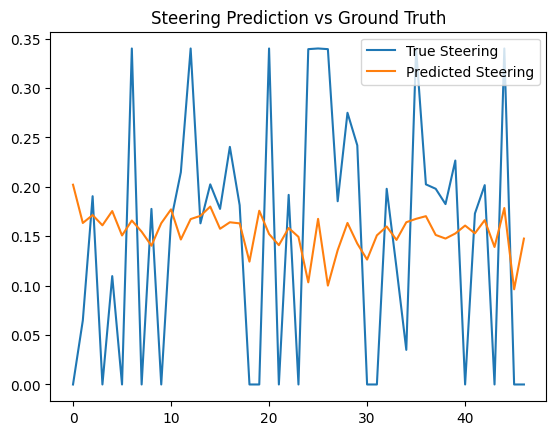

In [9]:
import matplotlib.pyplot as plt

plt.plot(y_test[:, 0], label='True Steering')
plt.plot(preds[:, 0], label='Predicted Steering')
plt.legend()
plt.title("Steering Prediction vs Ground Truth")
plt.show()
